# Data Preparation


The purpose of this notebook is to prepare data for machine learning models. It will use the data downloaded from Kaggle and reshape it to fit the input and output of machine learning models. 

After running this notebook, the data can be retrieved by Dataset.get_prepared_data().


In [1]:
# correct working directory.
# This is necessary for imports because the notebook is not in the main folder of the project. 
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer

from data.dataset import Dataset

dataset = Dataset()

c:\Users\frank\Documents\Teaching\LU\Spring2023\Machine Learning² Unit\Machine Learning Example Project


## Target format

Our Machine Learning problem is image classification. Given an image, we want to classify which pokemon types this image represents. 

Formally, we would like our dataset to be:
- X: One 120 x 120 x 3 vector, representing the image with r, g and b channels.
- y: One multi-hot encoded vector, representing all labels predicted for this pokemon. 

## X: Image Conversion

Here, we create the X dataset by loading each image and converting it into a suitable numpy aray. 

First, let's define a function that does this for a single image. From inspecting our data in data_exploration.ipynb, we know that we need to take care of...
1) reducing the channels for png images from 4 to 3.
2) adding white background to our png images

In addition, our function will convert the image values into numbers between 0 and 1, because machine learning models tend to work better with this type of normalized input.

After initial tests with model selection, we have returned to this cell and added one more preprocessing step:
3) color inversion. Colors are inverted such that white becomes (0,0,0). This is done to make the background color, which is white, carry less active information and thus cause less activation in a neural network. This was identified as a necessary step based on experiments with and without this operation which showed that Neural Networks perform significantly better with this preprocessing step.

In [2]:
def image_to_array(image) -> np.ndarray:
    # PNGs have 4 channels and need adjustments
    if image.mode == "RGBA":
        # add white background
        white_bg = Image.new(mode='RGBA', size=image.size, color=(255, 255, 255))
        image = Image.alpha_composite(im1=white_bg, im2=image)

    # normalize to values between 0 and 1
    data = np.array(object=image)
    data = data.astype(dtype=np.float32) / 255

    # Invert colors
    data = 1-data

    # Remove fourth channel, if it exists
    return data[:,:,:3]

Now we can apply thus function to each image to create our X dataset.

In [3]:
data = dataset.get_original_data()
X = np.empty(shape=[len(data),120,120,3])

for index in range(len(data)):
    pokemon_name = data.Name[index]
    pokemon_image = dataset.get_image(pokemon_name=pokemon_name)
    pokemon_data = image_to_array(image=pokemon_image)
    X[index] = pokemon_data

X.shape

(809, 120, 120, 3)

## y: Label Encoding
Second, we need to encode our labels. 
From data exploration, we know that we have a classification problem, where each pokemon may be associated with one or two classes. We will encode this using a MultiLabelBinarizer. The resulting encoding will be a vector of numbers, for example [0,1,1,0,0]. Each index represents a class. A 1 represents that the sample has this class and a 0 that it doesn't. 

As last time, let's create a convenience function first. This function will get a list of all laels for a pokemon. This is the format we will need for the LabelBinarizer

In [4]:
def get_classes(category1, category2) -> list:
    classes = [category1]

    # Some classes are None. we only add them if they aren't
    if not pd.isna(obj=category2):
        classes.append(category2)

    return classes

Now we can use this function to produce the right input for the binarizer and use the binarizer to create our y dataset. We will feed the binarizer with the labels retrieved from dataset.get_labels. This way we can guarantee that we use the same order of labels regardless of which notebook we work in.

In [5]:
data = dataset.get_original_data()
labels = dataset.get_labels()
mlb = MultiLabelBinarizer(classes=list(labels))

data["Combined_classes"] = data.apply(lambda row: get_classes(row.Type1, row.Type2), axis=1)  # type: ignore
y = mlb.fit_transform(data["Combined_classes"])

## Testing
Theoretically, we are ready to store our data. Practically, it's always a good idea to check our data again to make sure we didn't make any mistakes.

The below cell will pick a random pokemon and compare our prepared data to the actual data. By runing it a few times we should be able to convince ourselfes that our data processing has preserved the image and the original label.

Testing fearow at index 21

Label vector:  [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
Original classes:  Normal Flying
Predicted classes:  ['Flying', 'Normal']


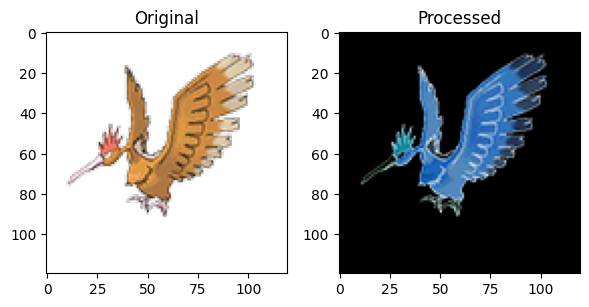

In [6]:
data = dataset.get_original_data()
labels = dataset.get_labels()
index = random.randint(a=0, b=len(data)) # insert specific index here, if you want to test with specific pokemon
name = data.Name[index]
image = dataset.get_image(name)
converted_image = X[index]

print(f"Testing {name} at index {index}", end="\n\n")

# Compare both images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(3*2, 3*1))
axes[0].imshow(X=image) # type: ignore
axes[0].set_title(label="Original")
axes[1].imshow(X=converted_image)
axes[1].set_title(label="Processed")

plt.tight_layout()

# Compare classes
print("Label vector: ",y[index])
print("Original classes: ", data.Type1[index], data.Type2[index])

classes = []

for label_index in range(len(labels)):
    if y[index][label_index] == 1:
        classes.append(labels[label_index])

print("Predicted classes: ", classes)

## Store Data
Finally, we store data in a file so we can load and use it whenever we need to.
The class Dataset provides store and load functionality for our prepared data. We just need to call it. 

In [7]:
dataset.store_prepared_data(X=X, y=y)   # type: ignore